In [2]:
%load_ext autoreload
%autoreload 2

import particle as pt
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mplhep
from scipy.stats import norm
from scipy.optimize import curve_fit
import matplotlib.mlab as mlab
import time
from matplotlib.colors import LogNorm
mplhep.style.use(mplhep.style.ROOT)
from pprint import pprint
from tqdm import tqdm
import polars as pl
import sys
import os
import particle
# using getlogin() returning username
user_name = os.getlogin()

sys.path.append(f'/home/{user_name}/Documents/cernbox/Atmos_Pandora/apc_atmo_repo/Anatree/')
from anatree_class import Anatree
from  ana_tools import *


plt.rcParams.update({'font.size': 16,
                     'grid.linestyle': '--',
                     'axes.grid': True,
                     'figure.autolayout': True,
                     'figure.figsize': [14,6]
                     })

anatree:Anatree

def selection_events(extras = ['']):
    r = ['subrun', 'event']
    if extras != ['']:
        r = r + extras
    return r
def get_event(subrun=0, event=1):
    return (pl.col('subrun')==subrun) & (pl.col('event') == event)

In [3]:
anatree = Anatree("/home/henrique/Documents/cernbox/Atmos_Pandora/data/atm_50k_hd_AV_2.5_random/anatree_hd_AV_2dot5_random_sum_300k.root", entry_start=0, entry_stop=1000, load_data=False)
anatree.tree:uproot.TTree
anatree.read_parquet('../../../../../data/atm_50k_hd_AV_2.5_random/parquet',batches=-1, concat=False)#, types=['nu','reco_tracks','reco_showers'])#, n_rows=100)

Reading nu files... 6/6
Reading geant files... 6/6
Reading reco_tracks files... 6/6
Reading reco_showers files... 6/6


In [4]:
nu = anatree.nu
geant = anatree.geant
shw = anatree.reco_showers
tracks = anatree.reco_tracks
showers = anatree.reco_showers
merged:pl.DataFrame
merged = 0
for i,n in enumerate(nu):
    df = anatree.get_full_reco_tracks(tracks[i], geant[i], nu[i])
    df = df.collect()
    if i == 0:
        merged = df
    else:
        merged = pl.concat([merged,df])

In [5]:
def create_division(df:pl.DataFrame, particle, axes = ['x','y','z']):

    list_ndf = [f'trkpidndf_pandoraTrack_{ax}' for ax in axes]

    for ax in axes:
        name_of_div_col = f'div_{particle}_{ax}'
        df = df.select(
            pl.all(),
            (pl.col(f'trkpidchi{particle}_pandoraTrack_{ax}')/pl.col(f'trkpidndf_pandoraTrack_{ax}')).alias(name_of_div_col)
        ).with_columns(
            pl.when(pl.col(f'trkpidndf_pandoraTrack_{ax}') <0 ).then(None).otherwise(pl.col(name_of_div_col)).alias(name_of_div_col),
            pl.when(pl.col(f'trkpidndf_pandoraTrack_{ax}') <0 ).then(0).otherwise(1).alias(f'ndiv_{ax}'),
            pl.when(pl.col(f'trkpidndf_pandoraTrack_{ax}') != pl.max(list_ndf)).then(0).otherwise(1).alias(f'{ax}_is_max_ndf'),
        )

    list_sum = [f'div_{particle}_{ax}' for ax in axes]
    list_div = [f'ndiv_{ax}' for ax in axes]

    df = df.with_columns( #first minimum, that works with nan
        (pl.min(list_sum)).alias(f'trkpid{particle}_min'),
    ).fill_null(0).with_columns(
        (pl.sum(list_sum)/pl.sum(list_div)).alias(f'trkpid{particle}_av'),
        (pl.col(f'div_{particle}_x')*pl.col('x_is_max_ndf') + 
         pl.col(f'div_{particle}_y')*pl.col('y_is_max_ndf') + 
         pl.col(f'div_{particle}_z')*pl.col('z_is_max_ndf')
        ).alias(f'trkpid{particle}_max')
       
    )
    return df
def pid_eval(df):
    df = create_division(df,'pr')
    df = create_division(df,'ka')
    df = create_division(df,'pi')
    df = create_division(df,'mu')
    return df

def particle_selection(df:pl.DataFrame, type='av'):
    """
    Make pid selection based on different methods
    type: list(str)
        `av` for average between chi2 x,y,z  \n
        `min` for getting minimum chi2  \n
        `max` for getting chi2 with maximum ndf  \n
    """

    df = df.with_columns(
        min_pid = pl.min(f'trkpidpr_{type}',f'trkpidka_{type}', f'trkpidpi_{type}',f'trkpidmu_{type}')
    ).with_columns(
        pid = pl.when(pl.col(f'trkpidpr_{type}')==pl.col('min_pid')).then(2212).otherwise(
        pl.when(pl.col(f'trkpidka_{type}')==pl.col('min_pid')).then(321).otherwise(
        pl.when(pl.col(f'trkpidpi_{type}')==pl.col('min_pid')).then(211).otherwise(
        pl.when(pl.col(f'trkpidmu_{type}')==pl.col('min_pid')).then(13).otherwise(
        0))))
    )

    return df
df = pid_eval(merged)
# why this consume so much ram? 
# q = tracks_pid.filter( pl.col('pid')==13)

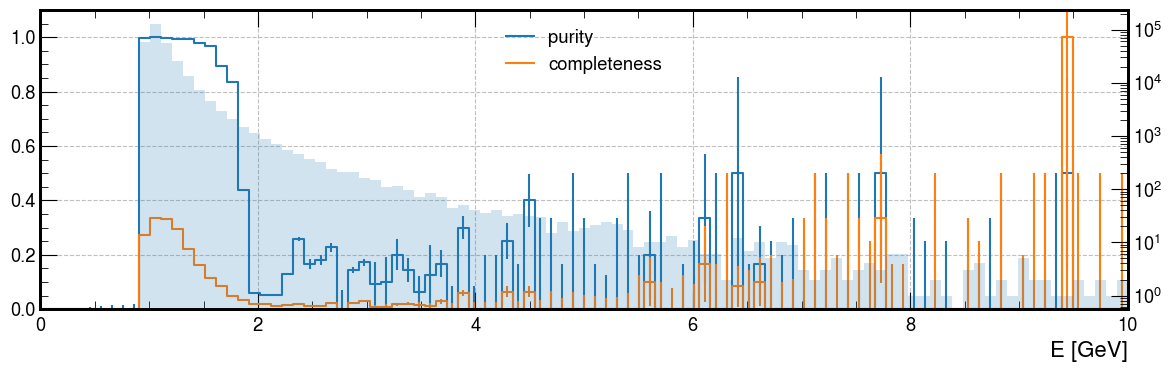

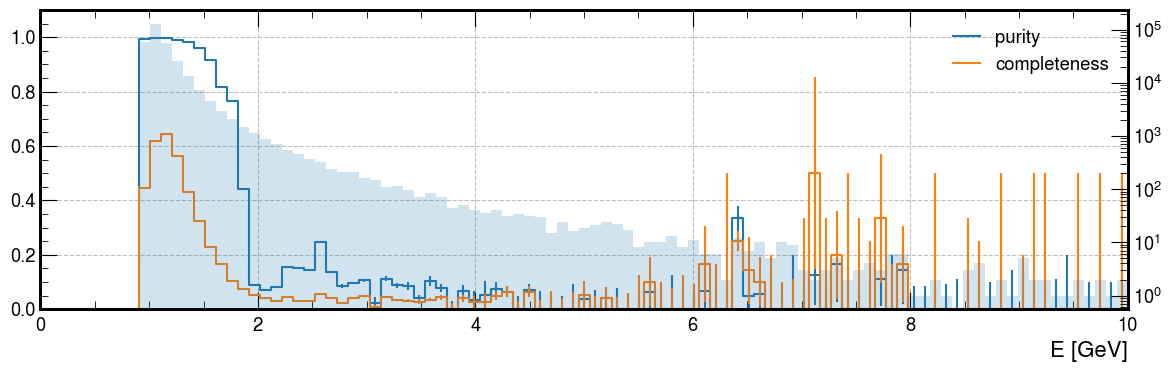

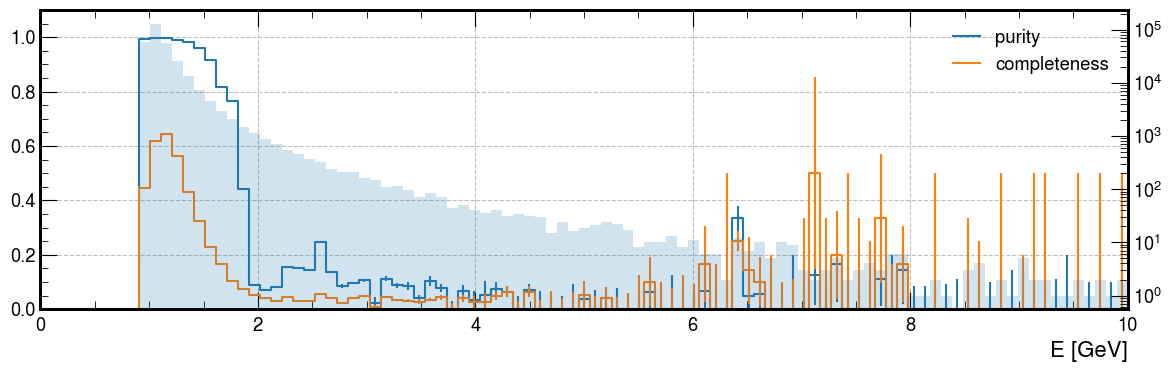

In [6]:
def fill_empty_categories(df, labels):

    empty_result = pl.DataFrame({ col: [0. for _ in labels] for col in df.columns })
    empty_result.with_columns(pl.Series(name='Ecut', values=labels))

    # works, but need to add manually.
    # empty_result = pl.DataFrame({'purity': 0., 'completeness': 0., 'total_events':0., 'Ecut': labels})
    empty_result = empty_result.with_columns(Ecut=pl.col('Ecut').cast(pl.Int16))

    out = pl.concat([empty_result,df],how='diagonal')
    out = out.groupby('Ecut').agg(
        pl.all().sum()
        # purity = pl.col("purity").sum(),
        # completeness = pl.col("completeness").sum(),
    ).sort('Ecut')
    return out

def eval_err(var:str):
    return pl.when(pl.col(var)!=0).then(1./pl.col(var).sqrt()).otherwise(1)

def eval_err_div(f:str, x:str, y:str, errx:str, erry:str):
    return pl.when(pl.col(x)!=0).then((pl.col(f)/pl.col(x)).pow(2)*((pl.col(y)*pl.col(errx)).pow(2) + (pl.col(x)*pl.col(erry)).pow(2)).sqrt()).otherwise(
        pl.when(pl.col(y)>1).then((1./(pl.col(x) + pl.col(y))).pow(2)*((pl.col(y)*pl.col(errx)).pow(2) + (pl.col(x)*pl.col(erry)).pow(2)).sqrt()).otherwise(0.)
    )

def purity_evolution(df, Ebins, flavour):
    labels = list(map(str, np.arange(0, len(Ebins) + 1)))
    cats = df.with_columns(
        Ecut=df.get_column('Eng_geant').cut(Ebins, maintain_order=True, labels=labels).get_column('category').cast(pl.Int16),
        Ecutt=df.get_column('Eng_geant').cut(Ebins, maintain_order=True).get_column('category')
        )
        
    q = (
        cats.groupby('Ecut').agg(
            correct_pdg = pl.col('pid').filter(pl.col('pid') == flavour).filter(
                pl.col('pdg_geant').abs() == flavour).count().cast(pl.Float64),
            false_positive = pl.col('pid').filter(pl.col('pid') == flavour).filter(
                pl.col('pdg_geant').abs() != flavour).count().cast(pl.Float64),
            incorrect_pdg = pl.col('pid').filter(pl.col('pid') != flavour).filter(
                pl.col('pdg_geant').abs() == flavour).count().cast(pl.Float64),
            total_events = pl.col('pid').filter(
                pl.col('pdg_geant').abs() == flavour).count().cast(pl.Float64)

        ).fill_null(0).with_columns(
            purity = pl.col('correct_pdg')/
            (pl.col('correct_pdg') + pl.col("false_positive")),
            completeness = pl.col('correct_pdg') /
            (pl.col('correct_pdg') + pl.col("incorrect_pdg")),
        ).fill_nan(0).with_columns(
            err_correct_pdg = eval_err('correct_pdg'),
            err_false_positive = eval_err('false_positive'),
            err_incorrect_pdg = eval_err('incorrect_pdg'),
        ).sort('Ecut').select(
            pl.all(),
            errpurity = eval_err_div('purity','correct_pdg','false_positive','err_correct_pdg','err_false_positive'),
            errcompleteness  = eval_err_div('completeness','correct_pdg','incorrect_pdg','err_correct_pdg','err_incorrect_pdg'),
        )
    )
    # bins_center = (Ebins[1:] + Ebins[:-1])*0.5
    bins_center = Ebins
    bins_width = np.diff(Ebins)
    q = fill_empty_categories(q, labels)
    fig = plt.figure(figsize=(12,4))
    p = plt.step(bins_center, q.get_column('purity')[:-1], label='purity')
    c = plt.step(bins_center, q.get_column('completeness')[:-1], label='completeness')

    error_center = (bins_center[1:] + bins_center[:-1])/2
    point_purity = q.get_column('purity')[1:-1]
    err_purity = q.get_column('errpurity')[1:-1]
    point_completeness = q.get_column('completeness')[1:-1]
    err_completeness = q.get_column('errcompleteness')[1:-1]
    plt.errorbar(error_center, point_purity,ls='none', marker='none', yerr=err_purity, color=p[0].get_color())
    plt.errorbar(error_center, point_completeness,ls='none', marker='none', yerr=err_completeness, color=c[0].get_color())
    plt.xlabel("E [GeV]")
    plt.xlim(bins_center[0], bins_center[-1])
    plt.ylim(0,1.1)
    plt.legend()
    # plt.xscale('log')
    ax2 = plt.twinx()

    ax2.bar(bins_center[:-1], q.get_column('total_events')[1:-1], width=bins_width, align="edge", alpha=0.2, log=True)
    ax2.grid(False)
    # return fig

Ebins = np.logspace(-1,2, 10)
Ebins = np.linspace(0.,10,100)


pdg = 2212
tracks_pid = particle_selection(df, type='av')
purity_evolution(tracks_pid, Ebins, pdg);

test_min = particle_selection(df, 'min')
purity_evolution(test_min, Ebins, pdg)

test_max = particle_selection(df, 'max')
purity_evolution(test_min, Ebins, pdg)

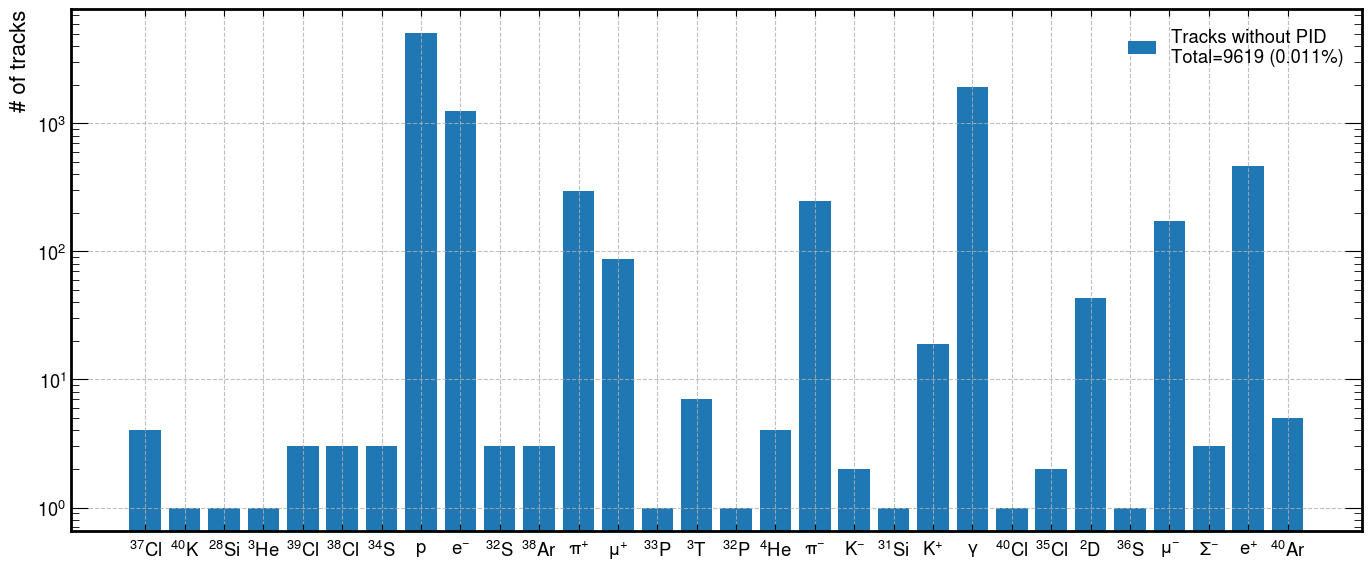

In [ ]:
df_no_pid = merged.filter(
    (pl.col('trkpidndf_pandoraTrack_x')<0) & (pl.col('trkpidndf_pandoraTrack_y') <0)  & (pl.col('trkpidndf_pandoraTrack_z')<0)
).select(
    pl.col(['subrun','event']),
    pl.col('pdg_geant').apply(lambda x: particle.Particle.from_pdgid(x).latex_name)
)

df_no_pid = df_no_pid.groupby('pdg_geant').agg(
    entries = pl.col('pdg_geant').count()
)


pdg_names = [fr'${pdg}$' for pdg in df_no_pid['pdg_geant']]
total = df_no_pid.select(pl.sum('entries')).to_numpy()[0][0]
plt.bar(pdg_names ,df_no_pid['entries'],label=f'Tracks without PID\nTotal={total} ({total/len(merged):.3f}%)')
plt.yscale('log')
plt.tick_params(axis='x',which='minor', bottom=False, top=False)
plt.tick_params(axis='x',which='major', size=5)
plt.ylabel('# of tracks')
plt.legend()

In [ ]:
df = merged
df = df.drop("trkg4id_pandoraTrack").insert_at_idx(2, df.get_column("trkg4id_pandoraTrack"))
df = df.filter(#groupby(['subrun','event']).agg(
    (pl.col('trkg4id_pandoraTrack').is_duplicated()).over(['subrun','event'])
)
df = df.select(
    pl.all(),
    diffx = pl.col('trkstartx_pandoraTrack') - pl.col('nuvtxx_truth'),
    diffy = pl.col('trkstarty_pandoraTrack') - pl.col('nuvtxy_truth'),
    diffz = pl.col('trkstartz_pandoraTrack') - pl.col('nuvtxz_truth'),
).select(
    pl.all(),
    diff = (pl.col('diffx').pow(2) + pl.col('diffy').pow(2) + pl.col('diffz').pow(2)).sqrt()
)
df.groupby(selection_events(['trkg4id_pandoraTrack'])).agg(
    pl.col('trkId_pandoraTrack'),
    pl.col('pdg_geant').first().apply(lambda x: particle.Particle.from_pdgid(x)),
    # pl.col('Mother_geant').first(),
    pl.col('trkPFParticleID_pandoraTrack'),
    pl.col('trkstarty_pandoraTrack'),
    # pl.col('diffx'),
    # pl.col('diffy'),
    # pl.col('diffz'),
    pl.col('diff'),
    pl.col('trklen_pandoraTrack'),
    ).sort(selection_events())

df.select(
    pl.col('trkpidbestplane_pandoraTrack'),
    pl.col('trkpidndf_pandoraTrack_x'),
    pl.col('trkpidndf_pandoraTrack_y'),
    pl.col('trkpidndf_pandoraTrack_z'),
)
# merged.filter(get_event(0,6)).select(
#     pl.col('^trkstart._pandoraTrack$'),
#     pl.col('pdg_geant').apply(lambda x: particle.Particle.from_pdgid(x))
# )

# merged.filter(get_event(0,3))

# df.groupby(selection_events()).agg(

# ).sort(selection_events())


trkpidbestplane_pandoraTrack,trkpidndf_pandoraTrack_x,trkpidndf_pandoraTrack_y,trkpidndf_pandoraTrack_z
i16,i32,i32,i32
2,38,19,46
0,6,-9999,-9999
0,54,21,45
0,19,19,-9999
1,-9999,24,11
1,9,40,27
0,1,-9999,-9999
0,2,3,3
2,6,-9999,16
